## Convolutional Neural Network for MNIST image classficiation 

In [230]:
import numpy as np
# from sklearn.utils.extmath import softmax
from matplotlib import pyplot as plt
import re
from tqdm import trange
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from sklearn.datasets import fetch_openml
import matplotlib.gridspec as gridspec

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Alternating Least Squares for Matrix Factorization

In [318]:
def coding_within_radius(X, W, H0, 
                         r=None, 
                         a1=0, #L1 regularizer
                         a2=0, #L2 regularizer
                         sub_iter=[5], 
                         stopping_grad_ratio=0.0001, 
                         nonnegativity=True,
                         subsample_ratio=1):
    """
    Find \hat{H} = argmin_H ( || X - WH||_{F}^2 + a1*|H| + a2*|H|_{F}^{2} ) within radius r from H0
    Use row-wise projected gradient descent
    """
    H1 = H0.copy()
    i = 0
    dist = 1
    idx = np.arange(X.shape[1])
    if subsample_ratio>1:  # subsample columns of X and solve reduced problem (like in SGD)
        idx = np.random.randint(X.shape[1], size=X.shape[1]//subsample_ratio)
    A = W.T @ W ## Needed for gradient computation
    B = W.T @ X[:,idx]
    while (i < np.random.choice(sub_iter)):
        if_continue = np.ones(H0.shape[0])  # indexed by rows of H
        H1_old = H1.copy()
        for k in [k for k in np.arange(H0.shape[0])]:
            grad = (np.dot(A[k, :], H1[:,idx]) - B[k,:] + a1 * np.ones(len(idx))) + a2 * 2 * np.sign(H1[k,idx])
            grad_norm = np.linalg.norm(grad, 2)
            step_size = (1 / (((i + 1) ** (1)) * (A[k, k] + 1)))
            if r is not None:  # usual sparse coding without radius restriction
                d = step_size * grad_norm
                step_size = (r / max(r, d)) * step_size

            if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
                H1[k, idx] = H1[k, idx] - step_size * grad

            if nonnegativity:
                H1[k,idx] = np.maximum(H1[k,idx], np.zeros(shape=(len(idx),)))  # nonnegativity constraint

        i = i + 1
    return H1

In [319]:
def ALS(X,
        n_components = 10, # number of columns in the dictionary matrix W
        n_iter=100,
        a0 = 0, # L1 regularizer for H
        a1 = 0, # L1 regularizer for W
        a12 = 0, # L2 regularizer for W
        H_nonnegativity=True,
        W_nonnegativity=True,
        compute_recons_error=False,
        subsample_ratio = 10):
    
        '''
        Given data matrix X, use alternating least squares to find factors W,H so that 
                                || X - WH ||_{F}^2 + a0*|H|_{1} + a1*|W|_{1} + a12 * |W|_{F}^{2}
        is minimized (at least locally)
        '''
        
        d, n = X.shape
        r = n_components
        
        #normalization = np.linalg.norm(X.reshape(-1,1),1)/np.product(X.shape) # avg entry of X
        #print('!!! avg entry of X', normalization)
        #X = X/normalization

        # Initialize factors 
        W = np.random.rand(d,r)
        H = np.random.rand(r,n) 
        # H = H * np.linalg.norm(X) / np.linalg.norm(H)
        for i in trange(n_iter):
            H = coding_within_radius(X, W.copy(), H.copy(), a1=a0, nonnegativity=H_nonnegativity, subsample_ratio=subsample_ratio)
            W = coding_within_radius(X.T, H.copy().T, W.copy().T, a1=a1, a2=a12, nonnegativity=W_nonnegativity, subsample_ratio=subsample_ratio).T
            if compute_recons_error and (i % 10 == 0) :
                print('iteration %i, reconstruction error %f' % (i, np.linalg.norm(X-W@H)**2))
        return W, H

In [323]:
# Simulated Data and its factorization 

W0 = np.random.rand(10,5)
H0 = np.random.rand(5,20)
X0 = W0 @ H0

W, H = ALS(X=X0, 
           n_components=5, 
           n_iter=100, 
           a0 = 0, # L1 regularizer for H
           a1 = 1, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity=True,
           W_nonnegativity=True,
           compute_recons_error=True,
           subsample_ratio=1)

print('reconstruction error (relative) = %f' % (np.linalg.norm(X0-W@H)**2/np.linalg.norm(X0)**2))
print('Dictionary error (relative) = %f' % (np.linalg.norm(W0 - W)**2/np.linalg.norm(W0)**2))
print('Code error (relative) = %f' % (np.linalg.norm(H0-H)**2/np.linalg.norm(H0)**2))


 67%|██████▋   | 67/100 [00:00<00:00, 280.63it/s]

iteration 0, reconstruction error 6.335252
iteration 10, reconstruction error 1.119085
iteration 20, reconstruction error 0.874973
iteration 30, reconstruction error 0.769795
iteration 40, reconstruction error 0.703294
iteration 50, reconstruction error 0.665510
iteration 60, reconstruction error 0.641669
iteration 70, reconstruction error 0.626891


100%|██████████| 100/100 [00:00<00:00, 351.32it/s]

iteration 80, reconstruction error 0.618200
iteration 90, reconstruction error 0.614744
reconstruction error (relative) = 0.001379
Dictionary error (relative) = 0.764469
Code error (relative) = 14.068346


# Learn dictionary of MNIST images 

In [274]:
def display_dictionary(W, save_name=None):
    k = int(np.sqrt(W.shape[0]))
    rows = int(np.sqrt(W.shape[1]))
    cols = int(np.sqrt(W.shape[1]))
    
    fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(6, 6),
                            subplot_kw={'xticks': [], 'yticks': []})
    for ax, i in zip(axs.flat, range(100)):
        ax.imshow(W.T[i].reshape(k, k), cmap="viridis", interpolation='nearest')
       
    plt.tight_layout()
    plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    
    if save_name is not None:
        plt.savefig( save_name, bbox_inches='tight')
    plt.show()

In [315]:
def display_dictionary_list(W_list, label_list, save_name=None):
    # Make plot
    
    # outer gridspec
    nrows=1
    ncols=3
    fig = plt.figure(figsize=(16, 5), constrained_layout=False)
    outer_grid = gridspec.GridSpec(nrows=nrows, ncols=ncols, wspace=0.1, hspace=0.05)

    # make nested gridspecs
    for i in range(1 * ncols):
        k = int(np.sqrt(W_list[i].shape[0]))
        sub_rows = int(np.sqrt(W_list[i].shape[1]))
        sub_cols = int(np.sqrt(W_list[i].shape[1]))

        inner_grid = outer_grid[i].subgridspec(sub_rows, sub_cols, wspace=0.05, hspace=0.05)

        for j in range(sub_rows*sub_cols):
            a = j % sub_cols #sub-lattice indices
            b = j // sub_cols 

            ax = fig.add_subplot(inner_grid[a, b])
            ax.imshow(W_list[i].T[j].reshape(k, k), cmap="viridis", interpolation='nearest')
            if (b>0):
                ax.set_yticks([])
            if (a < sub_rows-1):
                ax.set_xticks([])
            if (a == 0) and (b==2):
                #ax.set_title("W_nonnegativity$=$ %s \n H_nonnegativity$=$ %s" 
                #             % (str(nonnegativity_list[i][0]), str(nonnegativity_list[i][1])), y=1.2, fontsize=14) 
                ax.set_title(label_list[i], y=1.2, fontsize=14)
                
    # plt.suptitle('Dictionary learned from patches of size %d' % k, fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
    plt.savefig(save_name, bbox_inches='tight')

In [43]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values  ### Uncomment this line if you are having type errors in plotting. It is loading as a pandas dataframe, but our indexing is for numpy array. 
X = X / 255.

print('X.shape', X.shape)
print('y.shape', y.shape)

'''
Each row of X is a vectroization of an image of 28 x 28 = 784 pixels.  
The corresponding row of y holds the true class label from {0,1, .. , 9}.
'''

X.shape (70000, 784)
y.shape (70000,)


'\nEach row of X is a vectroization of an image of 28 x 28 = 784 pixels.  \nThe corresponding row of y holds the true class label from {0,1, .. , 9}.\n'

  6%|▌         | 3/50 [00:00<00:06,  7.37it/s]

iteration 0, reconstruction error 6320.791520


 24%|██▍       | 12/50 [00:01<00:03,  9.55it/s]

iteration 10, reconstruction error 1855.681026


 44%|████▍     | 22/50 [00:02<00:02, 11.21it/s]

iteration 20, reconstruction error 1522.911348


 68%|██████▊   | 34/50 [00:03<00:01, 12.35it/s]

iteration 30, reconstruction error 1362.117968


 84%|████████▍ | 42/50 [00:03<00:00, 12.69it/s]

iteration 40, reconstruction error 1266.661829


100%|██████████| 50/50 [00:04<00:00, 11.43it/s]


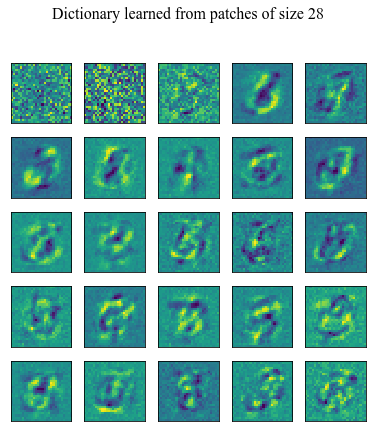

In [227]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T

W, H = ALS(X=X0, 
           n_components=25, 
           n_iter=50, 
           subsample_ratio=1, 
           W_nonnegativity=False,
           H_nonnegativity=False,
           compute_recons_error=True)

display_dictionary(W)

  3%|▎         | 3/100 [00:00<00:11,  8.25it/s]

iteration 0, reconstruction error 6232.659640


 12%|█▏        | 12/100 [00:01<00:09,  9.53it/s]

iteration 10, reconstruction error 1969.483977


 23%|██▎       | 23/100 [00:02<00:06, 12.22it/s]

iteration 20, reconstruction error 1592.970867


 33%|███▎      | 33/100 [00:02<00:05, 13.20it/s]

iteration 30, reconstruction error 1411.190120


 43%|████▎     | 43/100 [00:03<00:04, 12.66it/s]

iteration 40, reconstruction error 1314.751530


 53%|█████▎    | 53/100 [00:04<00:03, 12.68it/s]

iteration 50, reconstruction error 1253.380684


 63%|██████▎   | 63/100 [00:05<00:02, 13.37it/s]

iteration 60, reconstruction error 1215.739482


 73%|███████▎  | 73/100 [00:06<00:02, 12.45it/s]

iteration 70, reconstruction error 1193.492075


 83%|████████▎ | 83/100 [00:06<00:01, 13.33it/s]

iteration 80, reconstruction error 1180.340919


 93%|█████████▎| 93/100 [00:07<00:00, 13.73it/s]

iteration 90, reconstruction error 1171.588754


  2%|▏         | 2/100 [00:00<00:07, 12.81it/s]

iteration 0, reconstruction error 4782.161961


 12%|█▏        | 12/100 [00:00<00:06, 12.87it/s]

iteration 10, reconstruction error 1626.636676


 22%|██▏       | 22/100 [00:01<00:05, 13.44it/s]

iteration 20, reconstruction error 1148.445591


 32%|███▏      | 32/100 [00:02<00:05, 13.44it/s]

iteration 30, reconstruction error 1050.000633


 42%|████▏     | 42/100 [00:03<00:04, 13.21it/s]

iteration 40, reconstruction error 1013.780025


 52%|█████▏    | 52/100 [00:03<00:03, 13.03it/s]

iteration 50, reconstruction error 996.921305


 62%|██████▏   | 62/100 [00:04<00:02, 13.01it/s]

iteration 60, reconstruction error 989.474229


 72%|███████▏  | 72/100 [00:05<00:02, 13.17it/s]

iteration 70, reconstruction error 986.004115


 82%|████████▏ | 82/100 [00:06<00:01, 13.53it/s]

iteration 80, reconstruction error 984.161507


 92%|█████████▏| 92/100 [00:07<00:00, 13.26it/s]

iteration 90, reconstruction error 983.067992


  2%|▏         | 2/100 [00:00<00:07, 12.28it/s]

iteration 0, reconstruction error 4819.781220


 12%|█▏        | 12/100 [00:00<00:06, 12.73it/s]

iteration 10, reconstruction error 2195.378519


 22%|██▏       | 22/100 [00:01<00:05, 13.16it/s]

iteration 20, reconstruction error 1991.846413


 32%|███▏      | 32/100 [00:02<00:05, 12.57it/s]

iteration 30, reconstruction error 1892.091600


 42%|████▏     | 42/100 [00:03<00:04, 12.82it/s]

iteration 40, reconstruction error 1824.395638


 52%|█████▏    | 52/100 [00:04<00:04, 11.55it/s]

iteration 50, reconstruction error 1808.888995


 62%|██████▏   | 62/100 [00:05<00:03, 12.63it/s]

iteration 60, reconstruction error 1804.859502


 72%|███████▏  | 72/100 [00:05<00:02, 12.72it/s]

iteration 70, reconstruction error 1803.188476


 82%|████████▏ | 82/100 [00:06<00:01, 12.84it/s]

iteration 80, reconstruction error 1801.941208


 92%|█████████▏| 92/100 [00:07<00:00, 12.82it/s]

iteration 90, reconstruction error 1774.348904


100%|██████████| 100/100 [00:07<00:00, 12.53it/s]


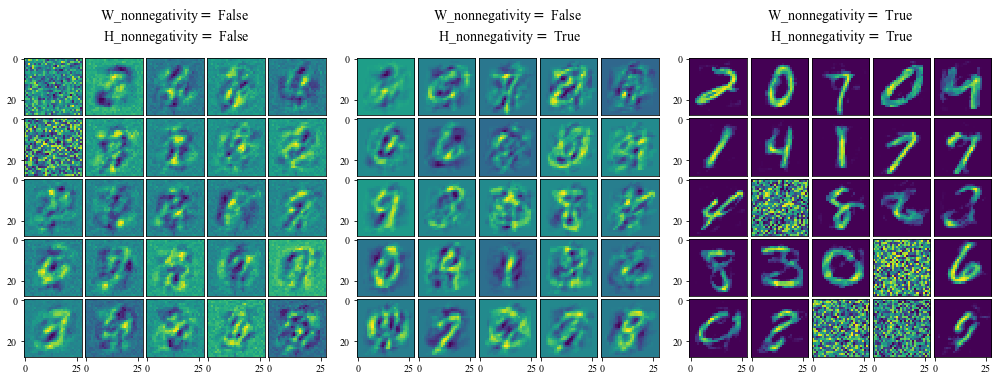

In [284]:
idx = np.random.choice(np.arange(X.shape[1]), 100)

X0 = X[idx,:].T
n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    


label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %2.f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %2.f" % W_sparsity[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex1.pdf")

In [143]:
def random_padding(img, thickness=1):
    # img = a x b image 
    [a,b] = img.shape
    Y = np.zeros(shape=[a+thickness, b+thickness])
    r_loc = np.random.choice(np.arange(thickness+1))
    c_loc = np.random.choice(np.arange(thickness+1))
    Y[r_loc:r_loc+a, c_loc:c_loc+b] = img
    return Y

def list2onehot(y, list_classes):
    """
    y = list of class lables of length n
    output = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    """
    Y = np.zeros(shape = [len(y), len(list_classes)], dtype=int)
    for i in np.arange(Y.shape[0]):
        for j in np.arange(len(list_classes)):
            if y[i] == list_classes[j]:
                Y[i,j] = 1
    return Y

def onehot2list(y, list_classes=None):
    """
    y = n x k array, i th row = one-hot encoding of y[i] (e.g., [0,0,1,0,0])
    output =  list of class lables of length n
    """
    if list_classes is None:
        list_classes = np.arange(y.shape[1])

    y_list = []
    for i in np.arange(y.shape[0]):
        idx = np.where(y[i,:]==1)
        idx = idx[0][0]
        y_list.append(list_classes[idx])
    return y_list

In [144]:
def sample_multiclass_MNIST_padding(list_digits=['0','1', '2'], full_MNIST=[X,y], padding_thickness=10):
    # get train and test set from MNIST of given digits
    # e.g., list_digits = ['0', '1', '2']
    # pad each 28 x 28 image with zeros so that it has now "padding_thickness" more rows and columns
    # The original image is superimposed at a uniformly chosen location 
    if full_MNIST is not None:
        X, y = full_MNIST
    else:
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
        X = X / 255.
    Y = list2onehot(y.tolist(), list_digits)
    
    idx = [i for i in np.arange(len(y)) if y[i] in list_digits] # list of indices where the label y is in list_digits
    
    X01 = X[idx,:]
    y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in trange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        img_padded = random_padding(X01[i,:].reshape(28,28), thickness=padding_thickness)
        img_padded_vec = img_padded.reshape(1,-1)
        if U<0.8:
            X_train.append(img_padded_vec[0,:].copy())
            y_train.append(y01[i,:].copy())
        else:
            X_test.append(img_padded_vec[0,:].copy())
            y_test.append(y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    return X_train, X_test, y_train, y_test

  2%|▏         | 2/100 [00:00<00:15,  6.17it/s]

iteration 0, reconstruction error 12667.385862


 12%|█▏        | 12/100 [00:01<00:13,  6.50it/s]

iteration 10, reconstruction error 4222.883648


 22%|██▏       | 22/100 [00:03<00:13,  5.92it/s]

iteration 20, reconstruction error 3503.542790


 32%|███▏      | 32/100 [00:05<00:10,  6.51it/s]

iteration 30, reconstruction error 3156.454865


 41%|████      | 41/100 [00:06<00:11,  5.11it/s]

iteration 40, reconstruction error 2949.972732


 52%|█████▏    | 52/100 [00:08<00:07,  6.37it/s]

iteration 50, reconstruction error 2831.524406


 62%|██████▏   | 62/100 [00:10<00:05,  6.70it/s]

iteration 60, reconstruction error 2760.183629


 72%|███████▏  | 72/100 [00:11<00:05,  5.55it/s]

iteration 70, reconstruction error 2712.124801


 82%|████████▏ | 82/100 [00:13<00:02,  6.35it/s]

iteration 80, reconstruction error 2677.079646


 92%|█████████▏| 92/100 [00:15<00:01,  6.66it/s]

iteration 90, reconstruction error 2649.561611


  2%|▏         | 2/100 [00:00<00:15,  6.42it/s]

iteration 0, reconstruction error 7583.940273


 12%|█▏        | 12/100 [00:01<00:14,  6.09it/s]

iteration 10, reconstruction error 4502.151691


 21%|██        | 21/100 [00:03<00:13,  5.94it/s]

iteration 20, reconstruction error 3403.152178


 32%|███▏      | 32/100 [00:05<00:10,  6.30it/s]

iteration 30, reconstruction error 2741.188882


 42%|████▏     | 42/100 [00:06<00:09,  6.39it/s]

iteration 40, reconstruction error 2466.140422


 52%|█████▏    | 52/100 [00:08<00:08,  5.89it/s]

iteration 50, reconstruction error 2365.688859


 62%|██████▏   | 62/100 [00:10<00:06,  6.08it/s]

iteration 60, reconstruction error 2320.019503


 72%|███████▏  | 72/100 [00:11<00:04,  6.43it/s]

iteration 70, reconstruction error 2295.385244


 82%|████████▏ | 82/100 [00:13<00:02,  6.76it/s]

iteration 80, reconstruction error 2278.940364


 91%|█████████ | 91/100 [00:14<00:01,  6.16it/s]

iteration 90, reconstruction error 2266.188688


  2%|▏         | 2/100 [00:00<00:16,  5.87it/s]

iteration 0, reconstruction error 7603.471466


 12%|█▏        | 12/100 [00:02<00:15,  5.76it/s]

iteration 10, reconstruction error 4954.799905


 22%|██▏       | 22/100 [00:03<00:12,  6.25it/s]

iteration 20, reconstruction error 4307.433108


 32%|███▏      | 32/100 [00:05<00:11,  5.82it/s]

iteration 30, reconstruction error 3704.846716


 42%|████▏     | 42/100 [00:07<00:09,  6.42it/s]

iteration 40, reconstruction error 3561.793915


 52%|█████▏    | 52/100 [00:09<00:09,  5.29it/s]

iteration 50, reconstruction error 3492.583799


 62%|██████▏   | 62/100 [00:10<00:05,  6.40it/s]

iteration 60, reconstruction error 3450.489902


 72%|███████▏  | 72/100 [00:12<00:04,  6.38it/s]

iteration 70, reconstruction error 3401.372649


 82%|████████▏ | 82/100 [00:14<00:02,  6.06it/s]

iteration 80, reconstruction error 3338.796891


 92%|█████████▏| 92/100 [00:15<00:01,  5.12it/s]

iteration 90, reconstruction error 3302.771860


100%|██████████| 100/100 [00:17<00:00,  5.64it/s]


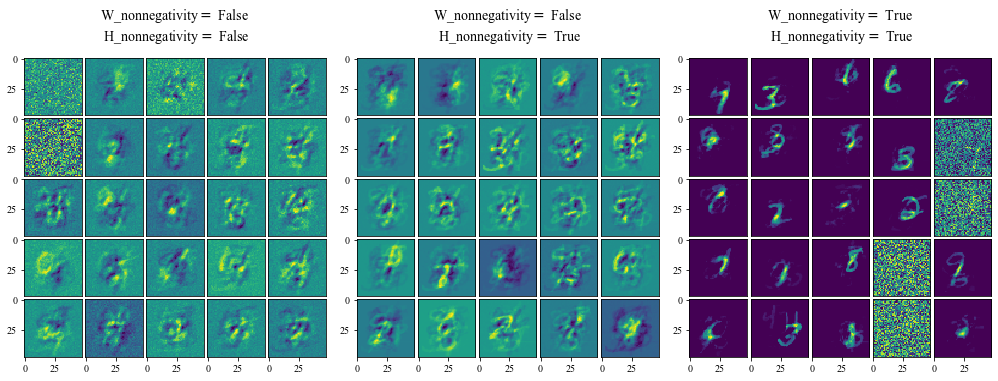

In [289]:
# Simple MNIST binary classification experiments 

list_digits=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

X_train, X_test, y_train, y_test = sample_multiclass_MNIST_padding(list_digits=list_digits, 
                                                                   full_MNIST=[X,y],
                                                                   padding_thickness=20)


idx = np.random.choice(np.arange(X_train.shape[1]), 100)
X0 = X_train[idx,:].T

n_iter = 100
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %2.f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %2.f" % W_sparsity[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "MNIST_NMF_ex2.pdf")

## Dictionary Learing for Face datasets

In [200]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=np.random.seed(0))
n_samples, n_features = faces.shape

# global centering
#faces_centered = faces - faces.mean(axis=0)

# local centering
#faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
print("faces_centered.shape", faces_centered.shape)

Dataset consists of 400 faces
faces_centered.shape (400, 4096)


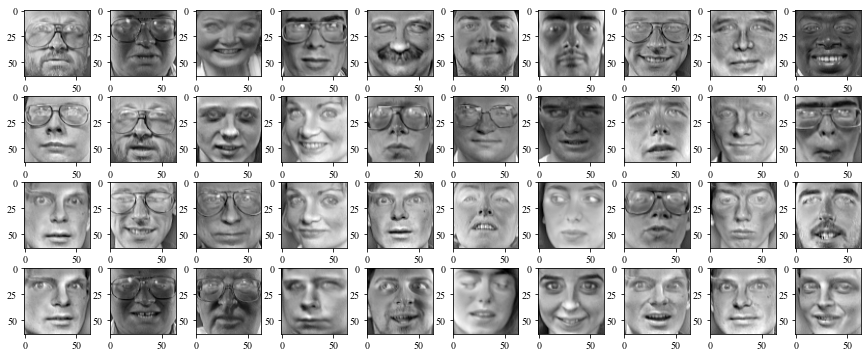

In [201]:
# Plot some sample images 
ncols = 10
nrows = 4
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[15, 6.5])
for j in np.arange(ncols):
    for i in np.arange(nrows):
        ax[i,j].imshow(faces_centered[i*ncols + j].reshape(64,64), cmap="gray")
        #if i == 0:
        #    ax[i,j].set_title("label$=$%s" % y[idx_subsampled[i]], fontsize=14) 
        # ax[i].legend()
plt.subplots_adjust(wspace=0.3, hspace=-0.1)
plt.savefig('Faces_ex1.pdf', bbox_inches='tight')

  0%|          | 1/200 [00:00<01:33,  2.13it/s]

iteration 0, reconstruction error 69615.858108


  6%|▌         | 11/200 [00:05<01:32,  2.05it/s]

iteration 10, reconstruction error 15060.845264


 10%|█         | 21/200 [00:10<01:34,  1.89it/s]

iteration 20, reconstruction error 12593.085854


 16%|█▌        | 31/200 [00:15<01:20,  2.09it/s]

iteration 30, reconstruction error 11470.503822


 20%|██        | 41/200 [00:19<01:08,  2.34it/s]

iteration 40, reconstruction error 10794.881111


 26%|██▌       | 51/200 [00:24<01:02,  2.39it/s]

iteration 50, reconstruction error 10365.317671


 30%|███       | 61/200 [00:28<00:58,  2.37it/s]

iteration 60, reconstruction error 10025.021448


 36%|███▌      | 71/200 [00:32<00:55,  2.32it/s]

iteration 70, reconstruction error 9729.752908


 40%|████      | 81/200 [00:36<00:50,  2.36it/s]

iteration 80, reconstruction error 9459.372603


 46%|████▌     | 91/200 [00:40<00:45,  2.40it/s]

iteration 90, reconstruction error 9204.261705


 50%|█████     | 101/200 [00:44<00:41,  2.40it/s]

iteration 100, reconstruction error 8986.542255


 56%|█████▌    | 111/200 [00:49<00:42,  2.11it/s]

iteration 110, reconstruction error 8821.770252


 60%|██████    | 121/200 [00:54<00:38,  2.08it/s]

iteration 120, reconstruction error 8698.636302


 66%|██████▌   | 131/200 [00:59<00:31,  2.18it/s]

iteration 130, reconstruction error 8604.005385


 70%|███████   | 141/200 [01:03<00:26,  2.22it/s]

iteration 140, reconstruction error 8526.984712


 76%|███████▌  | 151/200 [01:08<00:23,  2.11it/s]

iteration 150, reconstruction error 8466.295004


 80%|████████  | 161/200 [01:13<00:19,  2.02it/s]

iteration 160, reconstruction error 8407.646013


 86%|████████▌ | 171/200 [01:18<00:14,  2.02it/s]

iteration 170, reconstruction error 8352.113544


 90%|█████████ | 181/200 [01:23<00:09,  2.07it/s]

iteration 180, reconstruction error 8297.757463


 96%|█████████▌| 191/200 [01:27<00:04,  2.01it/s]

iteration 190, reconstruction error 8253.813169


  0%|          | 1/200 [00:00<01:46,  1.88it/s]

iteration 0, reconstruction error 28412.345419


  6%|▌         | 11/200 [00:05<01:28,  2.13it/s]

iteration 10, reconstruction error 12427.077730


 10%|█         | 21/200 [00:10<01:27,  2.04it/s]

iteration 20, reconstruction error 8660.991387


 16%|█▌        | 31/200 [00:15<01:26,  1.95it/s]

iteration 30, reconstruction error 7496.884730


 20%|██        | 41/200 [00:20<01:20,  1.98it/s]

iteration 40, reconstruction error 6946.724384


 26%|██▌       | 51/200 [00:25<01:20,  1.84it/s]

iteration 50, reconstruction error 6813.961827


 30%|███       | 61/200 [00:30<01:04,  2.14it/s]

iteration 60, reconstruction error 6762.929010


 36%|███▌      | 71/200 [00:34<00:58,  2.22it/s]

iteration 70, reconstruction error 6738.392728


 40%|████      | 81/200 [00:39<00:50,  2.34it/s]

iteration 80, reconstruction error 6725.329275


 46%|████▌     | 91/200 [00:43<00:47,  2.32it/s]

iteration 90, reconstruction error 6717.419509


 50%|█████     | 101/200 [00:47<00:41,  2.40it/s]

iteration 100, reconstruction error 6712.172508


 56%|█████▌    | 111/200 [00:51<00:37,  2.34it/s]

iteration 110, reconstruction error 6708.426829


 60%|██████    | 121/200 [00:56<00:33,  2.36it/s]

iteration 120, reconstruction error 6705.677931


 66%|██████▌   | 131/200 [01:00<00:31,  2.22it/s]

iteration 130, reconstruction error 6703.516310


 70%|███████   | 141/200 [01:04<00:24,  2.37it/s]

iteration 140, reconstruction error 6701.840205


 76%|███████▌  | 151/200 [01:09<00:20,  2.41it/s]

iteration 150, reconstruction error 6700.462123


 80%|████████  | 161/200 [01:13<00:17,  2.19it/s]

iteration 160, reconstruction error 6699.316007


 86%|████████▌ | 171/200 [01:18<00:13,  2.10it/s]

iteration 170, reconstruction error 6698.384533


 90%|█████████ | 181/200 [01:23<00:09,  1.96it/s]

iteration 180, reconstruction error 6697.567750


 96%|█████████▌| 191/200 [01:28<00:04,  1.87it/s]

iteration 190, reconstruction error 6696.895720


  0%|          | 1/200 [00:00<01:38,  2.02it/s]

iteration 0, reconstruction error 28417.328074


  6%|▌         | 11/200 [00:05<01:34,  1.99it/s]

iteration 10, reconstruction error 23677.747405


 10%|█         | 21/200 [00:10<01:25,  2.10it/s]

iteration 20, reconstruction error 23143.707706


 16%|█▌        | 31/200 [00:15<01:21,  2.07it/s]

iteration 30, reconstruction error 22866.250540


 20%|██        | 41/200 [00:20<01:17,  2.04it/s]

iteration 40, reconstruction error 22603.871477


 26%|██▌       | 51/200 [00:25<01:16,  1.94it/s]

iteration 50, reconstruction error 22417.041066


 30%|███       | 61/200 [00:29<01:06,  2.10it/s]

iteration 60, reconstruction error 22343.788166


 36%|███▌      | 71/200 [00:35<01:25,  1.50it/s]

iteration 70, reconstruction error 22296.351843


 40%|████      | 81/200 [00:42<01:20,  1.47it/s]

iteration 80, reconstruction error 22255.296723


 46%|████▌     | 91/200 [00:48<00:58,  1.85it/s]

iteration 90, reconstruction error 22232.771526


 50%|█████     | 101/200 [00:52<00:45,  2.15it/s]

iteration 100, reconstruction error 22186.451152


 56%|█████▌    | 111/200 [00:57<00:41,  2.13it/s]

iteration 110, reconstruction error 22167.633675


 60%|██████    | 121/200 [01:02<00:40,  1.96it/s]

iteration 120, reconstruction error 22155.914230


 66%|██████▌   | 131/200 [01:07<00:32,  2.15it/s]

iteration 130, reconstruction error 22141.761761


 70%|███████   | 141/200 [01:11<00:27,  2.12it/s]

iteration 140, reconstruction error 22126.851613


 76%|███████▌  | 151/200 [01:16<00:22,  2.20it/s]

iteration 150, reconstruction error 22112.490745


 80%|████████  | 161/200 [01:21<00:17,  2.26it/s]

iteration 160, reconstruction error 22092.639791


 86%|████████▌ | 171/200 [01:25<00:14,  2.01it/s]

iteration 170, reconstruction error 22061.329167


 90%|█████████ | 181/200 [01:30<00:09,  2.06it/s]

iteration 180, reconstruction error 22035.096521


 96%|█████████▌| 191/200 [01:35<00:04,  2.12it/s]

iteration 190, reconstruction error 22014.380073


100%|██████████| 200/200 [01:40<00:00,  1.99it/s]


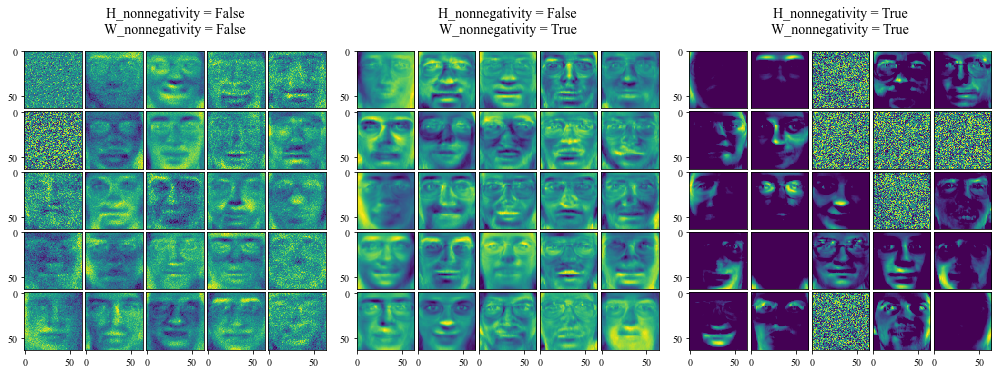

In [314]:
# Variable nonnegativity constraints 

X0 = faces_centered.T
#X0 /= 100 * np.linalg.norm(X0)

n_iter = 200
W_list = []

nonnegativitiy = [[False, False], [False, True], [True, True]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               W_nonnegativity=nonnegativitiy[i][0],
               H_nonnegativity=nonnegativitiy[i][1],
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "H_nonnegativity = %s" % nonnegativitiy[i][0] + "\n" + "W_nonnegativity = %s" % nonnegativitiy[i][1]
    label_list.append(label)
    
display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex1.pdf")



  0%|          | 0/200 [00:00<?, ?it/s]

X0.shape (4096, 400)


  0%|          | 1/200 [00:00<01:29,  2.21it/s]

iteration 0, reconstruction error 28434.903439


  6%|▌         | 11/200 [00:04<01:17,  2.44it/s]

iteration 10, reconstruction error 23603.023068


 10%|█         | 21/200 [00:08<01:10,  2.55it/s]

iteration 20, reconstruction error 23165.098320


 16%|█▌        | 31/200 [00:12<01:17,  2.18it/s]

iteration 30, reconstruction error 22876.255921


 20%|██        | 41/200 [00:17<01:07,  2.36it/s]

iteration 40, reconstruction error 22762.040285


 26%|██▌       | 51/200 [00:21<01:10,  2.12it/s]

iteration 50, reconstruction error 22659.651859


 30%|███       | 61/200 [00:26<01:00,  2.31it/s]

iteration 60, reconstruction error 22584.772459


 36%|███▌      | 71/200 [00:30<01:06,  1.93it/s]

iteration 70, reconstruction error 22503.727340


 40%|████      | 81/200 [00:36<01:08,  1.74it/s]

iteration 80, reconstruction error 22424.161301


 46%|████▌     | 91/200 [00:41<00:49,  2.22it/s]

iteration 90, reconstruction error 22386.701925


 50%|█████     | 101/200 [00:45<00:40,  2.44it/s]

iteration 100, reconstruction error 22348.146261


 56%|█████▌    | 111/200 [00:49<00:34,  2.56it/s]

iteration 110, reconstruction error 22306.926385


 60%|██████    | 121/200 [00:53<00:30,  2.63it/s]

iteration 120, reconstruction error 22263.398022


 66%|██████▌   | 131/200 [00:57<00:27,  2.55it/s]

iteration 130, reconstruction error 22224.758734


 70%|███████   | 141/200 [01:01<00:23,  2.51it/s]

iteration 140, reconstruction error 22192.416995


 76%|███████▌  | 151/200 [01:05<00:19,  2.55it/s]

iteration 150, reconstruction error 22171.634230


 80%|████████  | 161/200 [01:09<00:15,  2.57it/s]

iteration 160, reconstruction error 22148.961086


 86%|████████▌ | 171/200 [01:13<00:11,  2.45it/s]

iteration 170, reconstruction error 22127.647392


 90%|█████████ | 181/200 [01:17<00:09,  2.00it/s]

iteration 180, reconstruction error 22106.930528


 96%|█████████▌| 191/200 [01:23<00:05,  1.73it/s]

iteration 190, reconstruction error 22092.574579


  0%|          | 1/200 [00:00<01:55,  1.72it/s]

iteration 0, reconstruction error 29806.875876


  6%|▌         | 11/200 [00:04<01:12,  2.61it/s]

iteration 10, reconstruction error 24895.907120


 10%|█         | 21/200 [00:07<01:00,  2.94it/s]

iteration 20, reconstruction error 24874.986862


 16%|█▌        | 31/200 [00:10<00:44,  3.77it/s]

iteration 30, reconstruction error 24867.978283


 20%|██        | 41/200 [00:13<00:42,  3.76it/s]

iteration 40, reconstruction error 24862.723697


 26%|██▌       | 51/200 [00:15<00:39,  3.76it/s]

iteration 50, reconstruction error 24857.343349


 30%|███       | 61/200 [00:18<00:37,  3.75it/s]

iteration 60, reconstruction error 24852.953814


 36%|███▌      | 71/200 [00:21<00:33,  3.80it/s]

iteration 70, reconstruction error 24851.055631


 40%|████      | 81/200 [00:23<00:31,  3.73it/s]

iteration 80, reconstruction error 24850.376097


 46%|████▌     | 91/200 [00:26<00:29,  3.68it/s]

iteration 90, reconstruction error 24849.986335


 50%|█████     | 101/200 [00:29<00:26,  3.79it/s]

iteration 100, reconstruction error 24849.721007


 56%|█████▌    | 111/200 [00:31<00:25,  3.53it/s]

iteration 110, reconstruction error 24849.527389


 60%|██████    | 121/200 [00:34<00:23,  3.33it/s]

iteration 120, reconstruction error 24849.377748


 66%|██████▌   | 131/200 [00:38<00:21,  3.21it/s]

iteration 130, reconstruction error 24849.259837


 70%|███████   | 141/200 [00:41<00:18,  3.27it/s]

iteration 140, reconstruction error 24849.167496


 76%|███████▌  | 151/200 [00:44<00:13,  3.57it/s]

iteration 150, reconstruction error 24849.091987


 80%|████████  | 161/200 [00:46<00:10,  3.68it/s]

iteration 160, reconstruction error 24849.028675


 86%|████████▌ | 171/200 [00:49<00:07,  3.67it/s]

iteration 170, reconstruction error 24848.974735


 90%|█████████ | 181/200 [00:52<00:05,  3.68it/s]

iteration 180, reconstruction error 24848.928130


 96%|█████████▌| 191/200 [00:54<00:02,  3.62it/s]

iteration 190, reconstruction error 24848.887545


  0%|          | 0/200 [00:00<?, ?it/s]<ipython-input-318-3f680851322b>:32: RuntimeWarning: divide by zero encountered in double_scalars
  if step_size * grad_norm / np.linalg.norm(H1_old, 2) > stopping_grad_ratio:
  0%|          | 1/200 [00:00<01:15,  2.65it/s]

iteration 0, reconstruction error 31568.116510


  6%|▌         | 11/200 [00:04<01:21,  2.33it/s]

iteration 10, reconstruction error 22339.691414


 10%|█         | 21/200 [00:09<01:26,  2.06it/s]

iteration 20, reconstruction error 21769.743899


 16%|█▌        | 31/200 [00:14<01:19,  2.12it/s]

iteration 30, reconstruction error 21604.846333


 20%|██        | 41/200 [00:18<01:11,  2.23it/s]

iteration 40, reconstruction error 21507.255139


 26%|██▌       | 51/200 [00:23<01:08,  2.17it/s]

iteration 50, reconstruction error 21465.622120


 30%|███       | 61/200 [00:28<01:02,  2.21it/s]

iteration 60, reconstruction error 21437.928452


 36%|███▌      | 71/200 [00:32<00:58,  2.21it/s]

iteration 70, reconstruction error 21418.482647


 40%|████      | 81/200 [00:36<00:52,  2.27it/s]

iteration 80, reconstruction error 21404.093610


 46%|████▌     | 91/200 [00:41<00:48,  2.24it/s]

iteration 90, reconstruction error 21392.932779


 50%|█████     | 101/200 [00:45<00:45,  2.19it/s]

iteration 100, reconstruction error 21383.556315


 56%|█████▌    | 111/200 [00:51<00:57,  1.56it/s]

iteration 110, reconstruction error 21375.308696


 60%|██████    | 121/200 [00:58<01:07,  1.17it/s]

iteration 120, reconstruction error 21367.893124


 66%|██████▌   | 131/200 [01:04<00:38,  1.78it/s]

iteration 130, reconstruction error 21361.106102


 70%|███████   | 141/200 [01:09<00:30,  1.91it/s]

iteration 140, reconstruction error 21354.826190


 76%|███████▌  | 151/200 [01:16<00:30,  1.61it/s]

iteration 150, reconstruction error 21348.936554


 80%|████████  | 161/200 [01:22<00:24,  1.60it/s]

iteration 160, reconstruction error 21343.291751


 86%|████████▌ | 171/200 [01:28<00:16,  1.78it/s]

iteration 170, reconstruction error 21337.846473


 90%|█████████ | 181/200 [01:33<00:09,  1.97it/s]

iteration 180, reconstruction error 21332.807621


 96%|█████████▌| 191/200 [01:38<00:04,  2.08it/s]

iteration 190, reconstruction error 21328.118398


100%|██████████| 200/200 [01:42<00:00,  1.95it/s]


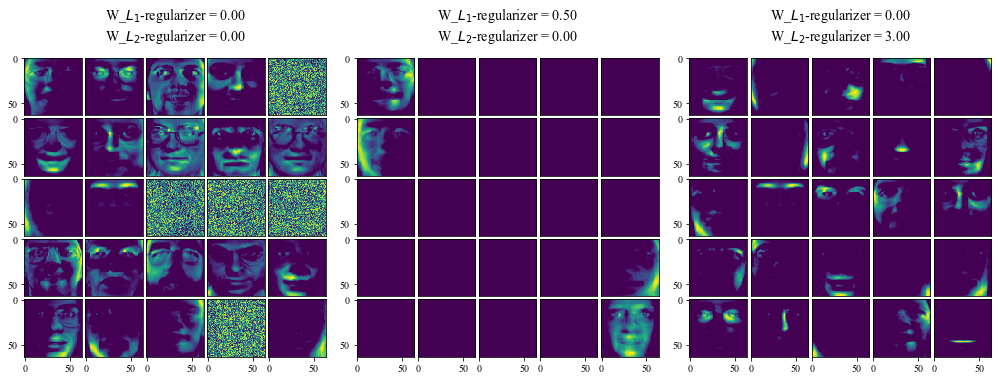

In [324]:
# Variable regularizer for W

X0 = faces_centered.T
print('X0.shape', X0.shape)

n_iter = 200
W_list = []

W_sparsity = [[0, 0], [0.5, 0], [0, 3]]

for i in np.arange(3): 
    W, H = ALS(X=X0, 
               n_components=25, 
               n_iter=n_iter, 
               subsample_ratio=1, 
               a1 = W_sparsity[i][0], # L1 regularizer for W
               a12 = W_sparsity[i][1], # L2 regularizer for W
               W_nonnegativity=True,
               H_nonnegativity=True,
               compute_recons_error=True)
    W_list.append(W)
    

label_list = []
for i in np.arange(len(W_sparsity)):
    label = "W_$L_{1}$-regularizer = %.2f" % W_sparsity[i][0] + "\n" + "W_$L_{2}$-regularizer = %.2f" % W_sparsity[i][1]
    label_list.append(label)

display_dictionary_list(W_list=W_list, label_list = label_list, save_name = "Face_NMF_ex2.pdf")

## Topic modeling for 20Newsgroups dataset

In [ ]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import entropy
import pandas as pd

In [ ]:
remove = ('headers','footers','quotes')
stopwords_list = stopwords.words('english')
stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])

categories = [
 'comp.graphics',
 'comp.sys.mac.hardware',
 'misc.forsale',
 'rec.motorcycles',
 'rec.sport.baseball',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.religion.misc'
 ]

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_labels = newsgroups_train.target
# remove numbers
data_cleaned = [re.sub(r'\d+','', file) for file in newsgroups_train.data]

# print 10 random documents
#for i in np.arange(10):
#    idx = np.random.choice(len(data_cleaned))
#    print('>>>> %i th doc \n\n %s \n\n' % (idx, data_cleaned[idx]))
    
print('len(newsgroups_labels)', len(newsgroups_labels))
print('newsgroups_labels', newsgroups_labels)

print('data_cleaned[1]', data_cleaned[1])
print('newsgroups_labels[1]', newsgroups_labels[1])

In [ ]:
# vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectorizer_BOW = CountVectorizer(stop_words=stopwords_list)
vectors_BOW = vectorizer_BOW.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
vectorizer = TfidfVectorizer(stop_words=stopwords_list)
vectors = vectorizer.fit_transform(data_cleaned).transpose()  # words x docs  # in the form of sparse matrix
idx_to_word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

print('>>>> vectors.shape', vectors.shape)
i = 4257
print('newsgroups_labels[i]', newsgroups_labels[i])
print('>>>> data_cleaned[i]', data_cleaned[i])
# print('>>>> vectors[:,i] \n', vectors[:,i])


a = vectors[:,i].todense() 
I = np.where(a>0)

count_list = []
word_list = []

for j in np.arange(len(I[0])):
    # idx = np.random.choice(I[0])
    idx = I[0][j]
    # print('>>>> %i th coordinate <===> %s, count %i' % (idx, idx_to_word[idx], vectors[idx, i]))
    count_list.append([idx, vectors_BOW[idx, i], vectors[idx, i]])
    word_list.append(idx_to_word[idx])

d = pd.DataFrame(data=np.asarray(count_list).T, columns=word_list).T
d.columns = ['Coordinate', 'Bag-of-words', 'tf-idf']
cols = ['Coordinate', 'Bag-of-words']
d[cols] = d[cols].applymap(np.int64)

print(d)

In [ ]:
def sample_multiclass_20NEWS(list_classes=[0, 1], full_data=None, vectorizer = 'tf-idf', verbose=True):
    # get train and test set from 20NewsGroups of given categories
    # vectorizer \in ['tf-idf', 'bag-of-words']
    # documents are loaded up from the following 10 categories
    categories = [
     'comp.graphics',
     'comp.sys.mac.hardware',
     'misc.forsale',
     'rec.motorcycles',
     'rec.sport.baseball',
     'sci.med',
     'sci.space',
     'talk.politics.guns',
     'talk.politics.mideast',
     'talk.religion.misc'
     ]
    
    data_dict = {}
    data_dict.update({'categories': categories})
    
    if full_data is None:
        remove = ('headers','footers','quotes')
        stopwords_list = stopwords.words('english')
        stopwords_list.extend(['thanks','edu','also','would','one','could','please','really','many','anyone','good','right','get','even','want','must','something','well','much','still','said','stay','away','first','looking','things','try','take','look','make','may','include','thing','like','two','or','etc','phone','oh','email'])  
        
        newsgroups_train_full = fetch_20newsgroups(subset='train', categories=categories, remove=remove) # raw documents
        newsgroups_train = [re.sub(r'\d+','', file) for file in newsgroups_train_full.data] # remove numbers (we are only interested in words)
        y = newsgroups_train_full.target # document class labels 
        Y = list2onehot(y.tolist(), list_classes)
       
        
        if vectorizer == 'tfidf':
            vectorizer = TfidfVectorizer(stop_words=stopwords_list) 
        else:
            vectorizer = CountVectorizer(stop_words=stopwords_list) 
            
        X = vectorizer.fit_transform(newsgroups_train) # words x docs  # in the form of sparse matrix
        X = np.asarray(X.todense())
        print('!! X.shape', X.shape)
        idx2word = np.array(vectorizer.get_feature_names())   # list of words that corresponds to feature coordinates

        data_dict.update({'newsgroups_train': data_cleaned})
        data_dict.update({'newsgroups_labels': y})
        data_dict.update({'feature_matrix': vectors})
        data_dict.update({'idx2word': idx2word})
        
    else:
        X, y = full_data

    idx = [i for i in np.arange(len(y)) if y[i] in list_classes] # list of indices where the label y is in list_classes

    X01 = X[idx,:]
    Y01 = Y[idx,:]

    X_train = []
    X_test = []
    y_test = [] # list of one-hot encodings (indicator vectors) of each label  
    y_train = [] # list of one-hot encodings (indicator vectors) of each label  

    for i in np.arange(X01.shape[0]):
        # for each example i, make it into train set with probabiliy 0.8 and into test set otherwise 
        U = np.random.rand() # Uniform([0,1]) variable
        if U<0.8:
            X_train.append(X01[i,:])
            y_train.append(Y01[i,:].copy())
        else:
            X_test.append(X01[i,:])
            y_test.append(Y01[i,:].copy())

    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    data_dict.update({'X_train': X_train})
    data_dict.update({'X_test': X_test})
    data_dict.update({'y_train': y_train})
    data_dict.update({'y_test': y_test})
  
    return X_train, X_test, y_train, y_test, data_dict 

# test 
X_train, X_test, y_train, y_test, data_dict = sample_multiclass_20NEWS(list_classes=[0, 1, 2], 
                                                                       vectorizer = 'bag-of-words',
                                                                       full_data=None)
print('X_train.shape', X_train.shape)
print('X_test.shape', X_test.shape)
print('y_train.shape', y_train.shape)
print('y_test.shape', y_test.shape)
print('y_test', y_test)
print('y_list', onehot2list(y_test))